# Subsetting Level 2 Data without Regridding

This notebook shows how STARE (Spatio-Temporal Adaptive Resolution Encoding) can be used to subset level 2 
satellite data without having to first regrid those data. 

STARE provides a powerful analytical tool, but in 
its native form, users must work with STARE indices to specify geospatial location and are very different 
from Latitude-Longitude pairs.

Here we show how to subset using STARE while working (and thinking!) in the traditional Latitude-Longitude
notation.


### Assumptions/Initial conditions:
* We have MODIS 05 Level 2 data and have built STARE sidecar files for those granules
* We have Hyrax running and providing access to those data
* We have loaded the STARE server functions that enable subsetting
* we know to use DAP4 because STARE requires 64-bit integer support
* The STARE C++ and pystare libraries are installed in addition to those packages listed below

In [178]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import numpy as np
import requests
import pystare as ps

import cartopy
import cartopy.crs as ccrs

### Get the Solar_Zenith data for one granule
This provides context for the rest of the notebook and also illustrates some of the capabilities of the netCDF4
and shows how retrieving netCDF4 files can be a useful way around the currently-limited DAP4 support in the 
Python code base. We hope that will be remedied soon...

In [179]:
granule = 'http://localhost:8080/opendap/data/stare/336-23xx.20201211/MOD05_L2.A2019336.2350.061.2019337072348.hdf'
granule_dap4 = 'dap4://localhost:8080/opendap/data/stare/336-23xx.20201211/MOD05_L2.A2019336.2350.061.2019337072348.hdf'
variables = 'Solar_Zenith;Latitude;Longitude'

!curl --silent --output Solar_Zenith.nc4 "http://localhost:8080/opendap/data/stare/336-23xx.20201211/MOD05_L2.A2019336.2350.061.2019337072348.hdf.dap.nc4?dap4.ce=Solar_Zenith;Latitude;Longitude"
!ls -lh Solar_Zenith.nc4


-rw-r--r--  1 jimg  staff   776K Sep 24 16:07 Solar_Zenith.nc4


In [180]:
nc = netCDF4.Dataset('./Solar_Zenith.nc4')

In [181]:
nc.variables.keys()

dict_keys(['Solar_Zenith', 'Latitude', 'Longitude'])

In [182]:
nc.variables['Solar_Zenith'].long_name

'Solar Zenith Angle, Cell to Sun'

In [183]:
nc.variables['Solar_Zenith'].shape

(406, 270)

In [184]:
nc.variables['Latitude']

<class 'netCDF4._netCDF4.Variable'>
float32 Latitude(Cell_Along_Swath_5km, Cell_Across_Swath_5km)
    units: degrees_north
    valid_range: [-90.  90.]
    _FillValue: -999.9
    long_name: Geodetic Latitude
    Parameter_Type: MODIS Input
    Cell_Along_Swath_Sampling: [   3 2028    5]
    Cell_Across_Swath_Sampling: [   3 1348    5]
    Geolocation_Pointer: Internal geolocation arrays
unlimited dimensions: 
current shape = (406, 270)
filling off

In [185]:
nc.variables['Longitude']

<class 'netCDF4._netCDF4.Variable'>
float32 Longitude(Cell_Along_Swath_5km, Cell_Across_Swath_5km)
    units: degrees_east
    valid_range: [-180.  180.]
    _FillValue: -999.9
    long_name: Geodetic Longitude
    Parameter_Type: MODIS Input
    Cell_Along_Swath_Sampling: [   3 2028    5]
    Cell_Across_Swath_Sampling: [   3 1348    5]
    Geolocation_Pointer: Internal geolocation arrays
unlimited dimensions: 
current shape = (406, 270)
filling off

In [186]:
nc.variables['Solar_Zenith']

<class 'netCDF4._netCDF4.Variable'>
int16 Solar_Zenith(Cell_Along_Swath_5km, Cell_Across_Swath_5km)
    coordinates: Latitude Longitude
    valid_range: [    0 18000]
    _FillValue: -32768
    long_name: Solar Zenith Angle, Cell to Sun
    units: degrees
    Parameter_Type: MODIS Input
    Cell_Along_Swath_Sampling: [   3 2028    5]
    Cell_Across_Swath_Sampling: [   3 1348    5]
    Geolocation_Pointer: Internal geolocation arrays
    scale_factor: 0.009999999776482582
    add_offset: 0.0
unlimited dimensions: 
current shape = (406, 270)
filling off

### Plot the data
This makes it easy to see the spatial extent of the data for this variable in this granule. In a more complete
example, we would search over a number of granules, something STARE is also very useful for, and then pick ones
that have data in our Region Of Interest (ROI).

In [187]:
sz = nc.variables['Solar_Zenith'][:,:]
lat = nc.variables['Latitude'][:,:]
lon = nc.variables['Longitude'][:,:]

print(f"Value range: {np.amin(sz)}, {np.amax(sz)}")
print(f"Lon/lat box: {np.amin(lon)}, {np.amax(lon)}, {np.amin(lat)}, {np.amax(lat)}")

Value range: 20.939999531954527, 48.21999892219901
Lon/lat box: 129.30384826660156, 166.734619140625, -57.58869552612305, -35.901309967041016


#### Set the levels for a contour plot based on the range of values in the data

In [188]:
levs = np.arange(20, 50, 0.1)

<function matplotlib.pyplot.show(*args, **kw)>

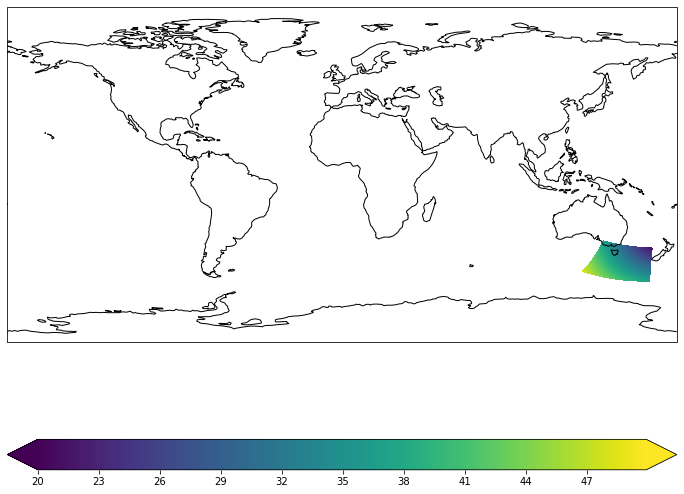

In [189]:

# These two lines are needed to make matplotlib plot figures inline and at a decent size.
# They are not needed in scripts.
%matplotlib inline
fig = plt.figure(figsize=[12,12])

ax = plt.subplot(projection=ccrs.PlateCarree())

# Add coastlines 
ax.coastlines()
# We need this for the coastlines to work until/unless the higher resolution coastlines
# can be made to work. Without 'global' MPL will try for a more detailed plot which requires
# a more detailed map which, see below, is not happening now...
ax.set_global()  

# Add extent - we'd like to focus into on the ROI, but that requires the detailed
# map which must be transferred over the net and that's blocked by the notebook.
# At least, I think that's the case... jhrg 9/23/21
#extent = [100, 180, -65, -25]#  Four numbers; lon, lat
# ax.set_extent(extent)

x1 = ax.contourf(lon, lat, sz, levs, extend='both')

fig.colorbar(x1, extend='both', orientation='horizontal', fraction=0.1)

plt.show


### Now lets subset to get data just south of Tasmania

We will reuse the URL (*granule*) but constrain the access using a server side function.

One powerful feature of server functions is that they support *functional composition*. 

The `stare_subset_array()` will subset an array and mask all the values not in the subset. This is really useful because the results are easy to work with in tools like *Panoply* or *Jupyter notebook*. The function
takes the name of an array, a file value for all those pixels not in the subset and a list of STARE indices that define the region of interest.

That's great, but a hitch is that most people are less familiar with STARE indices than lat/lon pairs and the set of STARE indices for a ROI can be quite long. Functional composition to the rescue!

The `stare_box()` function takes the corners of a box and returns the set of STARE indices that form a cover for that ROI. (Actually, stare_box() takes N points that form the ROI, but as a special case, two points are taken as the top-left and bottom-right points of a box. Apologies to the geographers in the audience).

The server side function looks like: `stare_subset_array(Solar_Zenith, 0.0, stare_box(-44.0, 144.0, -44.0, 148.0))`

We're going to get another netCDF file and we want that file to contain the `Latitude` and `Longitude` arrays as well so it's easy to plot the data (...as easy as it can be; YMMV). We will use the `identity()` server function to add those variables to the return value of the server function call.

The complete Constraint Expression will look like:

`stare_subset_array(Solar_Zenith, 0.0, stare_box(-45.0, 144.0, -44.0, 148.0)); identity(Latitude); identity(Longitude)`

This CE is passed to *curl* using `--data-urlencode` like this:

`--data-urlencode 'dap4.function=stare_subset_array(Solar_Zenith, -32768, stare_box(-45.0, 144.0, -44.0, 148.0)); identity(Latitude); identity(Longitude)'`

Note also that the URL Query String uses the *key* `dap4.function` and not `dap4ce` as was previously the case. 

### But wait, let's look at the STARE indices first
Since this is an example, let's look at the STARE indices and then see if we really only get data in the 
region they define. 

Define some helper functions to plot the STARE triangles and then call the `stare_box()` server function.
The function will return the STARE indices. We will ask for those as a CSV response to make the work easy.

In [190]:
def add_coastlines(figax, set_global=False):
    ax = figax[1]
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def stare_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,show=True
        ,color='xkcd:blue'
        ):

    if figax is None:
        fig,ax = plt.subplots(1, subplot_kw=plot_options)
        ax.set_global()
        ax.coastlines()
        figax = [fig,ax]
    else:
        ax = figax[1]
    
    if spatial_index_values is not None:
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        siv_triang = tri.Triangulation(lons, lats, intmat)
        ax.triplot(siv_triang, color=color, transform=plot_options['transform'])
    
    if show:
        plt.show()
        
    return figax


In [191]:
# granule = 'http://localhost:8080/opendap/data/stare/336-23xx.20201211/MOD05_L2.A2019336.2350.061.2019337072348.hdf'
# variables = 'Solar_Zenith;Latitude;Longitude'

# Functional constraint: stare_subset_array(Solar_Zenith, 0.0, stare_box(-45.0, 144.0, -44.0, 148.0)); identity(Latitude); identity(Longitude)
function_call = 'stare_box(-45.0, 144.0, -44.0, 148.0)'


# Request a CSV file (.csv) from a DAP4 data response(.dap)
ext = '.dap.csv'

payload = {'dap4.function': function_call}
r = requests.get(granule + ext, params=payload)

In [192]:
# Get the stare indices for the box
# It's a bit messy, so...

r.text

'Dataset: function_results\n/cover, 1299851442449809414, 1302666192216915974, 1303792092123758598, 1303932829612113926, 1304073567100469254, 1304214304588824582, 1326873040214032390, 1329687789981138950, 1330813689887981574, 1331235902353047558\n'

In [193]:
# ...let's clean it up

s_indices = r.text.strip().split(',')[1:]
s_indices

[' 1299851442449809414',
 ' 1302666192216915974',
 ' 1303792092123758598',
 ' 1303932829612113926',
 ' 1304073567100469254',
 ' 1304214304588824582',
 ' 1326873040214032390',
 ' 1329687789981138950',
 ' 1330813689887981574',
 ' 1331235902353047558']

### Plot the STARE indices for the box
In normal use, the whole idea of the `stare_box()` function is to avoid having to work with the STARE indices,
but for this example, it's useful to see them. In the next two frames we plot those indices, both at the global
and the local scale. NB: The indices are plotted in red

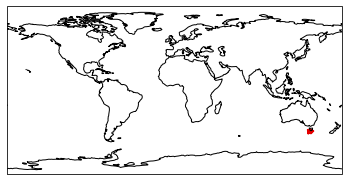

(<Figure size 432x288 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ff770b6aeb0>)

In [194]:
%matplotlib inline
figax = add_coastlines(plt.subplots(1, subplot_kw=plot_options), set_global=True)

stare_plot(s_indices, figax, show=True, color='xkcd:red')

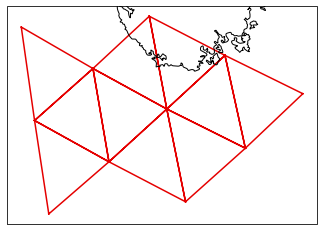

(<Figure size 432x288 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ff76862a1f0>)

In [195]:
%matplotlib inline
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

figax = add_coastlines(plt.subplots(1, subplot_kw=plot_options))
stare_plot(s_indices, figax, show=True, color='xkcd:red')


### Now let's return to the regular workflow and get the subset
We request the subset data and ask for it to be packaged in a netCDF4 file.

Here's a nice way to use curl with Python3's new variable substitution syntax. 

In [196]:

# granule = 'http://localhost:8080/opendap/data/stare/336-23xx.20201211/MOD05_L2.A2019336.2350.061.2019337072348.hdf'
# variables = 'Solar_Zenith;Latitude;Longitude'

# Functional constraint: stare_subset_array(Solar_Zenith, 0.0, stare_box(-45.0, 144.0, -44.0, 148.0)); identity(Latitude); identity(Longitude)
function_call = 'dap4.function=stare_subset_array(Solar_Zenith, -32768, stare_box(-40.0, 144.0, -44.0, 148.0)); identity(Latitude); identity(Longitude)'

# Save this to a file named 'Solar_Zenith_subset.nc4'
output = 'Solar_Zenith_subset.nc4'

# Request a netCDF4 file (nc4) using DAP4 (dap)
ext = '.dap.nc4'

!curl --output {output}  --data-urlencode "{function_call}" "{granule}{ext}"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  714k    0  714k  100   164   691k    158  0:00:01  0:00:01 --:--:--  692k


### Access the data
Open the file and read the Solar_Zenith variable, which will not be subset so that only the values in the ROI remain. All the values outside the ROI will be set to the missing data value. We read the missing data value at the beginning 
of the notebook when the granule was first accessed (it's '-32768' in the above call to `stare_subset_array()`).

In [197]:
nc2 = netCDF4.Dataset('./Solar_Zenith_subset.nc4')

In [198]:
sz_subset = nc2.variables['Solar_Zenith'][:,:]

# These should be the same as the previous lat and lon, but save them all the same
lat_subset = nc2.variables['Latitude'][:,:]
lon_subset = nc2.variables['Longitude'][:,:]

print(f"Value range: {np.amin(sz_subset)}, {np.amax(sz_subset)}")
print(f"Lon/lat box: {np.amin(lon_subset)}, {np.amax(lon_subset)}, {np.amin(lat_subset)}, {np.amax(lat_subset)}")

Value range: 33.369999254122376, 37.66999915800989
Lon/lat box: 129.30384826660156, 166.734619140625, -57.58869552612305, -35.901309967041016


In [199]:
# NB: we could change the levels used to make the contour plot, but using the same colors 
# makes it easier to compare the full data and sebset plots.

# levs = np.arange(20, 50, 0.1)

<function matplotlib.pyplot.show(*args, **kw)>

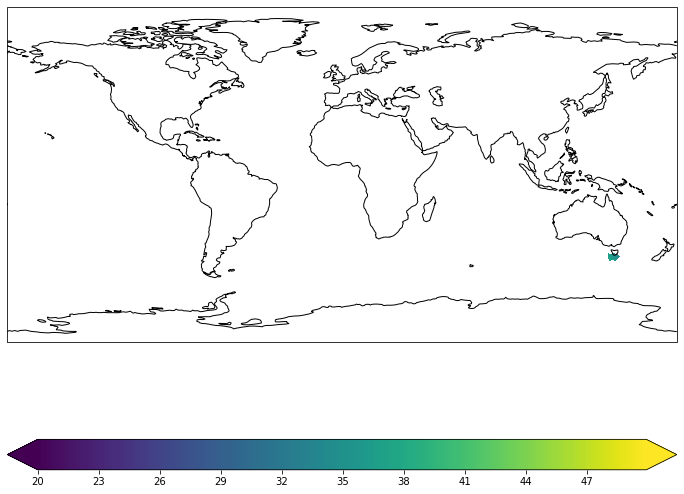

In [200]:
%matplotlib inline
fig2 = plt.figure(figsize=[12,12])

ax2 = plt.subplot(projection=ccrs.PlateCarree())

# Add coastlines 
ax2.coastlines()
ax2.set_global()  

# extent = [0, 180, 0, 90]#  Four numbers; lon then lat
# ax.set_extent(extent)

# Use the same 'levs' to make the plots easier to compare
x2 = ax2.contourf(lon_subset, lat_subset, sz_subset, levs, extend='both')

fig2.colorbar(x2, extend='both', orientation='horizontal', fraction=0.1)

plt.show


<function matplotlib.pyplot.show(*args, **kw)>

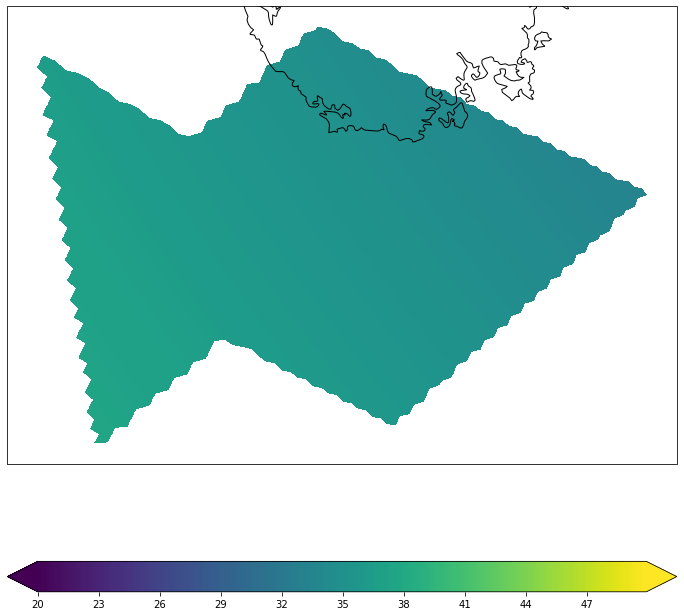

In [201]:
%matplotlib inline
fig2 = plt.figure(figsize=[12,12])

ax2 = plt.subplot(projection=ccrs.PlateCarree())

# Add coastlines 
ax2.coastlines()
# ax2.set_global()  

# Use the same 'levs' to make the plots easier to compare
x2 = ax2.contourf(lon_subset, lat_subset, sz_subset, levs, extend='both')

fig2.colorbar(x2, extend='both', orientation='horizontal', fraction=0.1)

plt.show
